<a href="https://colab.research.google.com/github/QiJin24/BPM_CausalReasoning/blob/main/MarkovainToSemiMarkovianGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install networkx==3.1

In [2]:
import networkx as nx

In [4]:
# A Markovian Graph 'G' as an input (with nodes being colored 'blue' if observed and 'grey' if unobserved)

# Casual graph: Fig. 1 -> C

# Let's assume V4 to be a grey variable such that V1 -> V4 -> D (we no longer have V1 -> D)

G = nx.DiGraph()
G.add_nodes_from([
    ('V3', {"color": "grey"}),
    ('V2', {"color": "blue"}),
    ('V1', {"color": "blue"}),
    ('D', {"color": "blue"}),
    ('V4', {"color": "grey"}),
    # ('V5', {"color": "blue"}),
])
G.add_edge('V3', 'V2')
G.add_edge('V3', 'V1')
G.add_edge('V2', 'V1')
G.add_edge('V2', 'D')
# G.add_edge('V1', 'D')

G.add_edge('V1', 'V4')
G.add_edge('V4', 'D')
# G.add_edge('V3', 'V5')

In [3]:
# Another random example to test

G = nx.DiGraph()
G.add_nodes_from([
    ('A', {"color": "grey"}),
    ('B', {"color": "grey"}),
    ('C', {"color": "blue"}),
    ('D', {"color": "blue"}),
    ('E', {"color": "blue"}),
    # ('V5', {"color": "blue"}),
])
G.add_edge('A', 'B')
# G.add_edge('B', 'C')
G.add_edge('B', 'D')
G.add_edge('B', 'E')
G.add_edge('C', 'E')
G.add_edge('A', 'C')

In [4]:
G.nodes()

NodeView(('A', 'B', 'C', 'D', 'E'))

In [5]:
G.edges()

OutEdgeView([('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'E'), ('C', 'E')])

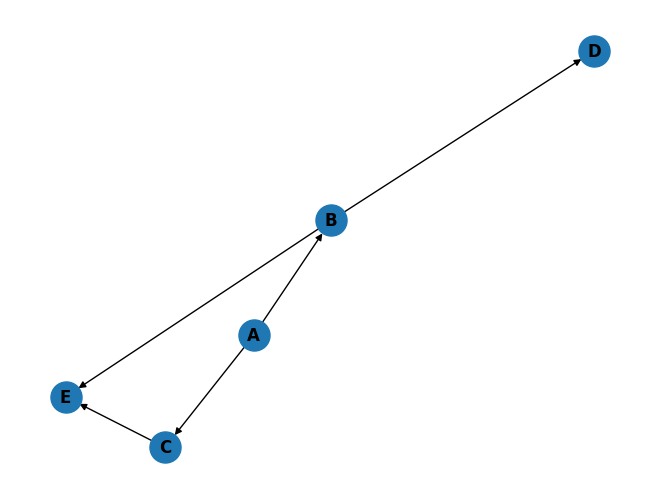

In [6]:
nx.draw(G, with_labels=True, font_weight='bold', node_size=500)

In [7]:
# Rule 1
# Adding all observed nodes to the new graph

G_sm = nx.DiGraph()
for node in G.nodes(data=True):
  # print(node)
  if node[1]['color'] == 'blue':
    G_sm.add_node(node[0])

G_sm.nodes()

NodeView(('C', 'D', 'E'))

In [8]:
# Rule 2
# Importing edges between two blue nodes
for edge in G.edges(data=True):
  from_node = edge[0]
  to_node = edge[1]
  from_node_color = G.nodes[from_node]['color']
  to_node_color = G.nodes[to_node]['color']
  if from_node_color =='blue' and to_node_color =='blue':
    G_sm.add_edge(edge[0], edge[1])

In [9]:
G_sm.edges()

OutEdgeView([('C', 'E')])

In [10]:
# Rule 3
# Adding edges for directed paths through grey nodes between two blue nodes


grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']
blue_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'blue']

for source in blue_nodes:
  for sink in blue_nodes:
    if source == sink or G.has_edge(source, sink):
      continue
    for path in nx.all_simple_paths(G, source=source, target=sink):
      counter = 0
      for between_node in path:
        if between_node in blue_nodes:
          counter += 1
      if counter == 2:
        G_sm.add_edge(source, sink)
        break

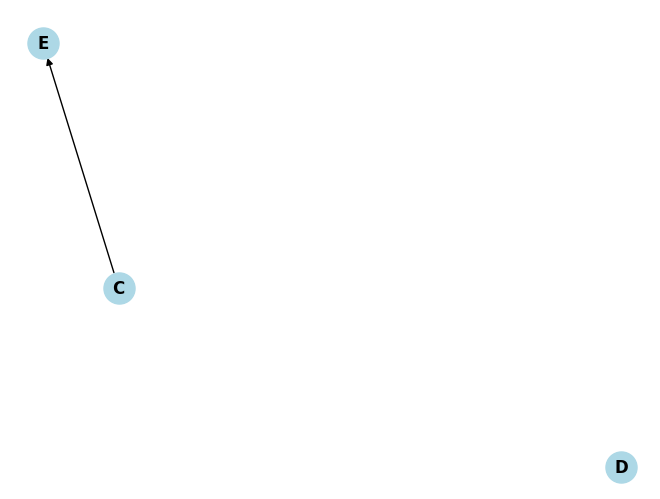

In [11]:
nx.draw(G_sm, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [12]:
# Rule 4
# Extracting the hidden confounders
confounding_list = []

for source in grey_nodes:
  potential_confounding = []
  for sink in blue_nodes:
    for path in nx.all_simple_paths(G, source=source, target=sink):
      red_flag = 0
      for between_node in path:
        if between_node in blue_nodes and between_node != sink:
          red_flag = 1
          break
      if red_flag == 0:
        potential_confounding.append(sink)
        break
  if len(potential_confounding) > 1:
    confounding_list.append(potential_confounding)

print(confounding_list)

[['C', 'D', 'E'], ['D', 'E']]


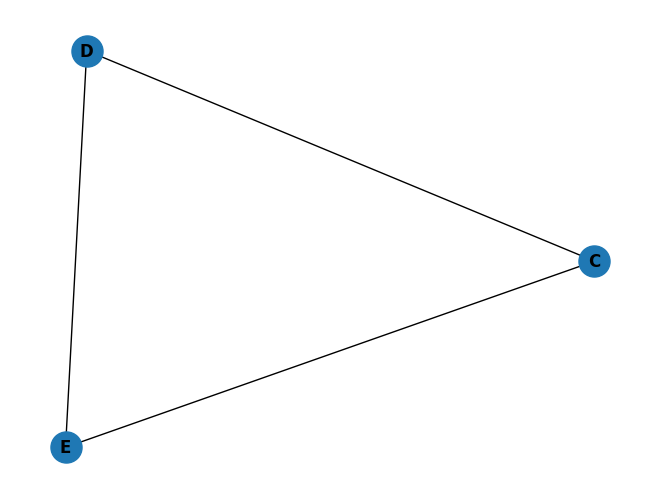

In [13]:
# Let's clean the output

# we construct a graph
G_confounded = nx.Graph()
for item in confounding_list:
  for i in range(len(item)):
      for j in range(i + 1 , len(item)):
        G_confounded.add_edge(item[i], item[j])

nx.draw(G_confounded, with_labels=True, font_weight='bold', node_size=500)

In [14]:
list(G_confounded.edges())

[('C', 'D'), ('C', 'E'), ('D', 'E')]

In [15]:
# Let's set up a function

# INPUT: A Markovian graph (with nodes being colored 'blue' if observed and 'grey' if unobserved
# OUTPUT: A Graph containing only solid arcs and a set of tuples(V_i, V_j) that are connected with dashed arcs

def markov_to_semimarkov(G):

  G_sm = nx.DiGraph()

  # Rule 1 ------- Adding all observed nodes to the new graph
  for node in G.nodes(data=True):
    if node[1]['color'] == 'blue':
      G_sm.add_node(node[0])

  # Rule 2 ------- Importing edges between two blue nodes
  for edge in G.edges(data=True):
    from_node = edge[0]
    to_node = edge[1]
    from_node_color = G.nodes[from_node]['color']
    to_node_color = G.nodes[to_node]['color']
    if from_node_color =='blue' and to_node_color =='blue':
      G_sm.add_edge(edge[0], edge[1])

  # Rule 3 ------- Adding edges for directed paths through grey nodes between two blue nodes
  grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']
  blue_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'blue']

  for source in blue_nodes:
    for sink in blue_nodes:
      if source == sink or G.has_edge(source, sink):
        continue
      for path in nx.all_simple_paths(G, source=source, target=sink):
        counter = 0
        for between_node in path:
          if between_node in blue_nodes:
            counter += 1
        if counter == 2:
          G_sm.add_edge(source, sink)
          break

  # Rule 4 ------- Extracting the hidden confounders
  confounding_list = []

  for source in grey_nodes:
    potential_confounding = []
    for sink in blue_nodes:
      for path in nx.all_simple_paths(G, source=source, target=sink):
        red_flag = 0
        for between_node in path:
          if between_node in blue_nodes and between_node != sink:
            red_flag = 1
            break
        if red_flag == 0:
          potential_confounding.append(sink)
          break
    if len(potential_confounding) > 1:
      confounding_list.append(potential_confounding)

  # we construct a graph for confounding arcs
  G_confounded = nx.Graph()
  for item in confounding_list:
    for i in range(len(item)):
        for j in range(i + 1 , len(item)):
          G_confounded.add_edge(item[i], item[j])
  # nx.draw(G_confounded, with_labels=True, font_weight='bold', node_size=500)

  return G_sm, list(G_confounded.edges())


[('C', 'D'), ('C', 'E'), ('D', 'E')]


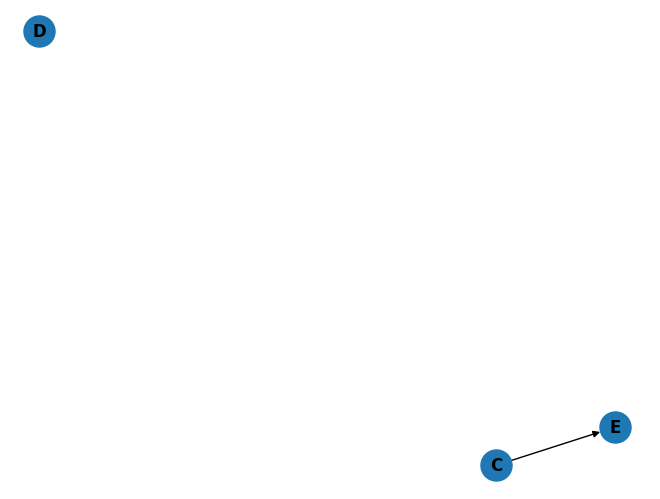

In [16]:
# Let's test the function

final_graph, confounded_vars = markov_to_semimarkov(G)
nx.draw(final_graph, with_labels=True, font_weight='bold', node_size=500)
print(confounded_vars)